In [22]:
import pandas as pd
import numpy as np
import gspread
from pydata_google_auth import get_user_credentials
from google.cloud import bigquery
from pycaret.clustering import *

project_id = 'ledger-fcc1e'
creds = get_user_credentials([
    'https://www.googleapis.com/auth/cloud-platform', 
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive',
])
client = bigquery.Client(project=project_id, credentials=creds)

gc = gspread.authorize(creds) 
pull_data = lambda query: client.query(query).result().to_dataframe()
get_worksheet = lambda key, name: gc.open_by_key(key).worksheet(name)

In [23]:
# query =\
# '''
# -- query for clustering v2
# WITH users AS (
#   SELECT DISTINCT user_id
#   FROM `ledger-fcc1e.dg_buku_trnsfmd.ppm_table`
#   WHERE last_transaction_date >= '2023-04-01'
# )

# , loyalty AS (
#   SELECT 
#     user_id, 
#     date_,
#     kyc_tier,
#     loyalty_tier,
#   FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
#   WHERE 
#     date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
#     AND kyc_tier <> 'NON_KYC'
# )

# , campaigns AS (
#   SELECT
#     user_id,
#     DATE_ADD(DATE_TRUNC(date_, MONTH), INTERVAL 1 MONTH) AS date_,
#     SUM(daily_OTHER_saldo) AS M1_campaign_saldo
#   FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
#   WHERE date_ BETWEEN '2023-04-01' AND '2023-07-31'
#   GROUP BY 1, 2
# )


# , payments AS (
#   SELECT
#     user_id,
#     DATE_ADD(DATE_TRUNC(transaction_date, MONTH), INTERVAL 1 MONTH) AS date_,
#     -- TRANSACTIONS
#     COUNT(DISTINCT IF(product_type IN ('Payment In', 'Payment Out'), transaction_id, NULL)) AS M1_core_count,
#     COUNT(DISTINCT IF(product_type IN ('PPOB'), transaction_id, NULL)) AS M1_ppob_count,
#     -- CUSTOMER
#     COUNT(DISTINCT IF(product_type = 'PPOB', beneficiaryid_ppob, NULL)) + COUNT(DISTINCT IF(product_type = 'Payment Out', destination_bank_account_number, NULL)) AS total_customer,
#   FROM `ledger-fcc1e.payment_reports.payments_ssot`
#   WHERE
#     status_v2 = 'COMPLETED'
#     AND transaction_date BETWEEN '2023-04-01' AND '2023-07-31'
#   GROUP BY 1, 2
# )

# , accountings AS (
#   SELECT DISTINCT
#     DATE_ADD(DATE_TRUNC(DATE(trans_createdAt), MONTH), INTERVAL 1 MONTH) AS date_,
#     createdByUser AS user_id,
#     COUNT(DISTINCT transactionId) AS M1_acc_count
#   FROM `ledger-fcc1e.bukuwarung_analytics.accounting_transactions_table_db`
#   WHERE DATE(trans_createdAt) BETWEEN '2023-04-01' AND '2023-07-31'
#   GROUP BY 1, 2
# )

# -- //this is a bit inefficient since i load the same table twice...
# -- //open to idea on how to do it better
# -- , banks AS (
# --   SELECT DISTINCT
# --     user_id,
# --     date_,
# --     ARRAY_AGG(money_in_channel) OVER(PARTITION BY user_id, date_ ORDER BY cnt_ DESC) [OFFSET(0)] AS main_funding_bank
# --   FROM (
# --     SELECT 
# --       user_id,
# --       DATE_ADD(DATE_TRUNC(transaction_date, MONTH), INTERVAL 1 MONTH) AS date_,
# --       money_in_channel,
# --       COUNT(*) AS cnt_
# --     FROM `ledger-fcc1e.payment_reports.payments_ssot`
# --     WHERE
# --       status_v2 = 'COMPLETED'
# --       AND product_type IN ('SALDO')
# --       AND transaction_date BETWEEN '2023-04-01' AND '2023-07-01'
# --     GROUP BY 1, 2, 3
# --   )
# -- )

# , referrals AS (
#   SELECT 
#     referrer AS user_id,
#     date_,
#     COUNT(DISTINCT referee) AS referee_count
#   FROM `ledger-fcc1e.trb_mxg_reports.referral_ssot` 
#   WHERE date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
#   GROUP BY 1, 2
# )

# , profiles AS (
#   SELECT DISTINCT
#     user_id,
#     acquisition_channel,
#     user_segment_sub_bucket,
#     first_user_date,
#     first_any_payment_date,
#     first_transaction_date
#   FROM `ledger-fcc1e.dg_buku_trnsfmd.user_profile_datamart`
# )

# , impressions AS (
#   SELECT
#     SUBSTR(phone_number, 4) AS user_id,
#     DATE_ADD(DATE_TRUNC(notification_date, MONTH), INTERVAL 1 MONTH) AS date_,
#     SUM(pn_count) AS send_count,
#     SUM(impressions_count) AS impressions_count,
#     SUM(read_count) AS read_count,
#     COUNT(DISTINCT user_activated) AS activated_count,
#     COUNT(DISTINCT user_converted) AS converted_count
#   FROM `ledger-fcc1e.crm_reports.crm_notification_service_campaign_performance`
#   WHERE 
#     notification_date BETWEEN '2023-04-01' AND '2023-08-31'
#     AND objective_code IN ('PAY_GEN', 'PAY_POUT', 'PPOB_PRE', 'PPOB_GEN', 'PAY', 'PPOB', 'SAL_TOPUP')
#   GROUP BY 1, 2
# )

# SELECT DISTINCT
#   user_id,
#   date_,
#   kyc_tier,
#   loyalty_tier,
#   (CASE WHEN M1_core_count IS NULL AND date_ >= first_any_payment_date THEN 0 ELSE M1_core_count END) AS M1_core_count,
#   (CASE WHEN M1_ppob_count IS NULL AND date_ >= first_any_payment_date THEN 0 ELSE M1_ppob_count END) AS M1_ppob_count,
#   (CASE WHEN M1_acc_count IS NULL AND date_ >= first_transaction_date THEN 0 ELSE M1_acc_count END) AS M1_acc_count,
#   M1_campaign_saldo,
#   -- (CASE WHEN M1_core_count > 0 THEN 1 ELSE M1_core_count END) AS M1_core_count,
#   -- (CASE WHEN M1_ppob_count > 0 THEN 1 ELSE M1_ppob_count END) AS M1_ppob_count,
#   -- (CASE WHEN M1_acc_count > 0 THEN 1 ELSE M1_acc_count END) AS M1_acc_count,
#   -- (CASE WHEN M1_campaign_saldo > 0 THEN 1 ELSE M1_campaign_saldo END) AS M1_campaign_saldo,
#   total_customer,
#   -- IFNULL(
#   --   IFNULL(
#   --     LAST_VALUE(main_funding_bank IGNORE NULLS) OVER(PARTITION BY user_id ORDER BY date_ ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW),
#   --     FIRST_VALUE(main_funding_bank IGNORE NULLS) OVER(PARTITION BY user_id ORDER BY date_ ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING)
#   --   ),
#   --   NULL
#   -- ) AS main_funding_bank,
#   (CASE WHEN referee_count > 0 THEN 1 ELSE 0 END) AS is_referrer,
#   acquisition_channel,
#   user_segment_sub_bucket,
#   DATE_DIFF(date_, first_user_date, DAY) AS age_on_platform_days,
#   CASE WHEN send_count > 0 THEN 1 ELSE IFNULL(send_count, 0) END AS is_send_m1,
#   CASE WHEN impressions_count > 0 THEN 1 ELSE IFNULL(impressions_count, 0) END AS is_imp_m1,
#   CASE WHEN read_count > 0 THEN 1 ELSE IFNULL(read_count, 0) END AS is_read_m1,
#   IFNULL(activated_count, 0) AS is_act_m1,
#   IFNULL(converted_count, 0) AS is_conv_m1
# FROM users -- active in last 12 months
# INNER JOIN loyalty USING (user_id) -- needs to be atleast KYC
# LEFT JOIN payments USING (user_id, date_) -- get Q2 transaction data
# -- LEFT JOIN banks USING (user_id, date_)
# LEFT JOIN referrals USING (user_id, date_)
# LEFT JOIN impressions USING (user_id, date_)
# LEFT JOIN accountings USING (user_id, date_)
# LEFT JOIN campaigns USING (user_id, date_)
# LEFT JOIN profiles USING (user_id)
# WHERE date_ < '2023-09-01'
# ORDER BY 1, 2
# '''
# raw = client.query(query).result().to_dataframe()
# raw.to_pickle('data/raw_data_v2.pkl')


raw = pd.read_pickle('data/raw_data_v2.pkl')


In [24]:
# -- QUERY TO GET IMPRESSIONS COUNT
# imp_query =\
# '''
# WITH users AS (
#   SELECT DISTINCT user_id
#   FROM `ledger-fcc1e.dg_buku_trnsfmd.ppm_table`
#   WHERE last_transaction_date >= '2023-04-01'
# )

# , loyalty AS (
#   SELECT user_id, date_
#   FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
#   WHERE 
#     date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
#     AND kyc_tier <> 'NON_KYC'
# )

# , impressions AS (
#   SELECT
#     SUBSTR(phone_number, 4) AS user_id,
#     DATE_TRUNC(notification_date, MONTH) AS date_,
#     SUM(pn_count) AS send_count,
#     SUM(impressions_count) AS impressions_count,
#     SUM(read_count) AS read_count,
#     COUNT(DISTINCT user_activated) AS activated_count,
#     COUNT(DISTINCT user_converted) AS converted_count
#   FROM `ledger-fcc1e.crm_reports.crm_notification_service_campaign_performance`
#   WHERE 
#     notification_date BETWEEN '2023-05-01' AND '2023-08-31'
#     AND objective_code IN ('PAY_GEN', 'PAY_POUT', 'PPOB_PRE', 'PPOB_GEN', 'PAY', 'PPOB', 'SAL_TOPUP')
#   GROUP BY 1, 2
# )

# SELECT
#   user_id,
#   date_,
#   CASE WHEN send_count > 0 THEN 1 ELSE IFNULL(send_count, 0) END AS send_count,
#   CASE WHEN impressions_count > 0 THEN 1 ELSE IFNULL(impressions_count, 0) END AS impressions_count,
#   CASE WHEN read_count > 0 THEN 1 ELSE IFNULL(read_count, 0) END AS read_count,
#   IFNULL(activated_count, 0) AS activated_count,
#   IFNULL(converted_count, 0) AS converted_count
# FROM users
# INNER JOIN loyalty USING (user_id)
# LEFT JOIN impressions USING (user_id, date_)
# WHERE send_count IS NOT NULL
# '''
# imp = client.query(imp_query).result().to_dataframe()
# imp.to_pickle('data/raw_imp_v2.pkl')


imp = pd.read_pickle('data/raw_imp_v2.pkl')

In [25]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203288 entries, 0 to 203287
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   user_id                  203288 non-null  object
 1   date_                    203288 non-null  dbdate
 2   kyc_tier                 203288 non-null  object
 3   loyalty_tier             203288 non-null  object
 4   M1_core_count            148648 non-null  Int64 
 5   M1_ppob_count            148648 non-null  Int64 
 6   M1_acc_count             201730 non-null  Int64 
 7   M1_campaign_saldo        203133 non-null  Int64 
 8   total_customer           87919 non-null   Int64 
 9   is_referrer              203288 non-null  Int64 
 10  acquisition_channel      203288 non-null  object
 11  user_segment_sub_bucket  203288 non-null  object
 12  age_on_platform_days     203288 non-null  Int64 
 13  is_send_m1               203288 non-null  Int64 
 14  is_imp_m1           

In [26]:
std_core = np.std(raw['M1_core_count'])
std_ppob = np.std(raw['M1_ppob_count'])
std_acc = np.std(raw['M1_acc_count'])
std_saldo = np.std(raw['M1_campaign_saldo'])
std_age = np.std(raw['age_on_platform_days'])

df =\
(
    raw
    .assign(
        # referee_count = lambda x: x.referee_count.fillna(0),
        date_ = lambda x: x.date_.astype(str),
        index_ = lambda x: x.user_id + " " + x.date_,

        # M1_core_count = lambda x: x.M1_core_count/std_core,
        # M1_acc_count = lambda x: x.M1_acc_count/std_acc,
        # M1_ppob_count = lambda x: x.M1_ppob_count/std_ppob,
        # M1_campaign_saldo = lambda x: x.M1_campaign_saldo/std_saldo,
        # age_on_platform_days = lambda x: x.age_on_platform_days/std_age,
        M1_core_count = lambda x: np.log1p(x.M1_core_count),
        M1_ppob_count = lambda x: np.log1p(x.M1_ppob_count),
        M1_acc_count = lambda x: np.log1p(x.M1_acc_count),
        M1_campaign_saldo = lambda x: np.log1p(x.M1_campaign_saldo),
        age_on_platform_days = lambda x: np.log1p(x.age_on_platform_days),

        is_send_m1 = lambda x: x.is_send_m1.fillna(0),
        is_imp_m1 = lambda x: x.is_imp_m1.fillna(0),
        is_read_m1 = lambda x: x.is_read_m1.fillna(0),
        is_act_m1 = lambda x: x.is_act_m1.fillna(0),
        is_conv_m1 = lambda x: x.is_conv_m1.fillna(0),
    )
    .drop(columns=['user_id', 'date_', 'is_send_m1', 'is_imp_m1', 'is_read_m1', 'is_act_m1', 'is_conv_m1', 'M1_campaign_saldo'])
    # .drop(columns=['user_id', 'date_', 'M1_core_count', 'M1_acc_count', 'M1_ppob_count'])
    # .drop(columns=['user_id', 'date_'])
    .set_index('index_')
)
df

,kyc_tier,loyalty_tier,M1_core_count,M1_ppob_count,M1_acc_count,total_customer,is_referrer,acquisition_channel,user_segment_sub_bucket,age_on_platform_days
index_,,,,,,,,,,
1161895687 2023-06-01,ADVANCED,Bronze,0.0,0.693147,1.791759,1,0,Organic Acquisition,pureO2O-PA+PP,5.736572
1161895687 2023-07-01,ADVANCED,Bronze,0.0,1.098612,0.0,2,0,Organic Acquisition,pureO2O-PA+PP,5.828946
1161895687 2023-08-01,ADVANCED,Bronze,0.0,3.135494,3.526361,16,0,Organic Acquisition,pureO2O-PA+PP,5.916202
8111010474 2023-05-01,ADVANCED,Bronze,0.0,0.0,0.693147,<NA>,0,Paid Acquisition,UNKNOWN,5.988961
8111010474 2023-06-01,ADVANCED,Bronze,0.0,0.0,0.0,<NA>,0,Paid Acquisition,UNKNOWN,6.063785
...,...,...,...,...,...,...,...,...,...,...
8999999365 2023-08-01,SUPREME,Gold,0.0,5.365976,0.0,158,0,Offline Acquisition,pureO2O-PAonly,6.426488
8999999557 2023-05-01,SUPREME,Diamond,6.747587,1.386294,0.0,437,0,Offline Acquisition,pureO2O-PAonly,6.152733
8999999557 2023-06-01,SUPREME,Diamond,6.602588,0.0,0.0,318,0,Offline Acquisition,pureO2O-PAonly,6.216606


In [27]:
df.describe()

,M1_core_count,M1_ppob_count,M1_acc_count,total_customer,is_referrer,age_on_platform_days
count,148648.0,148648.0,201730.0,87919.0,203288.0,203288.0
mean,0.856917,1.213106,1.377908,38.768036,0.05263,5.732194
std,1.557638,1.701817,2.012931,88.929275,0.223294,1.215126
min,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,2.0,0.0,4.990433
50%,0.0,0.0,0.0,11.0,0.0,6.244167
75%,1.098612,2.397895,2.833213,38.0,0.0,6.60665
max,8.2247,8.548886,9.481817,2907.0,1.0,7.26473


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 203288 entries, 1161895687 2023-06-01 to 8999999557 2023-08-01
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   kyc_tier                 203288 non-null  object 
 1   loyalty_tier             203288 non-null  object 
 2   M1_core_count            148648 non-null  Float64
 3   M1_ppob_count            148648 non-null  Float64
 4   M1_acc_count             201730 non-null  Float64
 5   total_customer           87919 non-null   Int64  
 6   is_referrer              203288 non-null  Int64  
 7   acquisition_channel      203288 non-null  object 
 8   user_segment_sub_bucket  203288 non-null  object 
 9   age_on_platform_days     203288 non-null  Float64
dtypes: Float64(4), Int64(2), object(4)
memory usage: 18.2+ MB


In [29]:
s = setup(
    df, 
    normalize=True, 
    ignore_features=['user_id'],
    use_gpu = True,
    session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(203288, 10)"
2,Transformed data shape,"(203288, 27)"
3,Ignore features,1
4,Ordinal features,1
5,Numeric features,6
6,Categorical features,4
7,Rows with missing values,56.8%
8,Preprocess,True
9,Imputation type,simple


In [30]:
kmeans = create_model('kmeans', num_clusters=6)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1845,20100.7181,1.8920,0,0,0


In [31]:
# plot_model(kmeans, 'tsne')

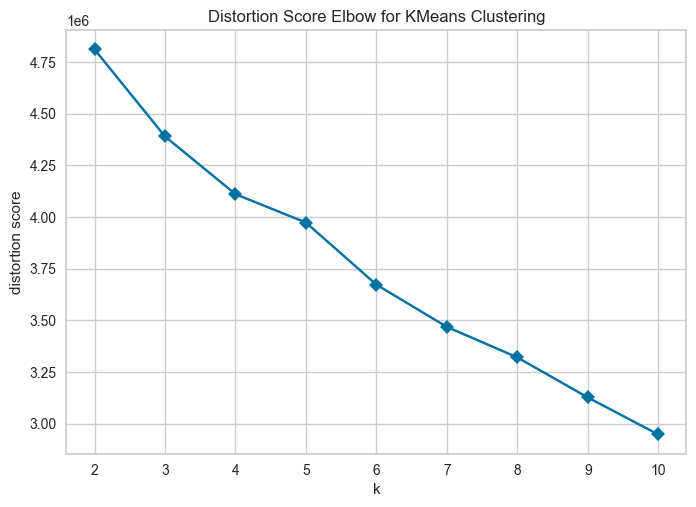

In [32]:
plot_model(kmeans, plot = 'elbow')

In [33]:
# plot_model(kmeans, plot = 'distribution')

In [34]:
imp_df =\
(
    imp
    .assign(
        date_ = lambda x: x.date_.astype(str)
    )
)

In [35]:
imp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84156 entries, 0 to 84155
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            84156 non-null  object
 1   date_              84156 non-null  object
 2   send_count         84156 non-null  Int64 
 3   impressions_count  84156 non-null  Int64 
 4   read_count         84156 non-null  Int64 
 5   activated_count    84156 non-null  Int64 
 6   converted_count    84156 non-null  Int64 
dtypes: Int64(5), object(2)
memory usage: 4.9+ MB


In [36]:
imp_df.describe()

,send_count,impressions_count,read_count,activated_count,converted_count
count,84156.0,84156.0,84156.0,84156.0,84156.0
mean,1.0,0.889895,0.679512,0.411165,0.221184
std,0.0,0.313023,0.466667,0.492048,0.415047
min,1.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,0.0,0.0,0.0
50%,1.0,1.0,1.0,0.0,0.0
75%,1.0,1.0,1.0,1.0,0.0
max,1.0,1.0,1.0,1.0,1.0


In [37]:
res =\
(
    assign_model(kmeans)
    .reset_index()
    .assign(
        user_id = lambda x: x.index_.str.split(" ", expand=False).str[0],
        date_ = lambda x: x.index_.str.split(" ", expand=False).str[1]
    )
    .drop(columns=['index_'])
    .merge(imp_df, how='right', on=['user_id', 'date_'])
    # .assign(
    #     impressions_count = lambda x: x.impressions_count.fillna(0),
    #     read_count = lambda x: x.read_count.fillna(0),
    # )
)

In [38]:
res.describe()

,M1_core_count,M1_ppob_count,M1_acc_count,total_customer,is_referrer,age_on_platform_days,send_count,impressions_count,read_count,activated_count,converted_count
count,77707.0,77707.0,83630.0,62490.0,84156.0,84156.0,84156.0,84156.0,84156.0,84156.0,84156.0
mean,1.209156,1.835294,0.872304,44.306225,0.064143,5.336137,1.0,0.889895,0.679512,0.411165,0.221184
std,1.761345,1.841635,1.726102,95.811087,0.245009,1.368854,0.0,0.313023,0.466667,0.492048,0.415047
min,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,3.0,0.0,4.382027,1.0,1.0,0.0,0.0,0.0
50%,0.0,1.386294,0.0,13.0,0.0,5.863631,1.0,1.0,1.0,0.0,0.0
75%,2.302585,3.401197,0.693147,45.0,0.0,6.461468,1.0,1.0,1.0,1.0,0.0
max,8.2247,8.548886,9.481817,2907.0,1.0,7.257708,1.0,1.0,1.0,1.0,1.0


In [39]:
res.groupby(['date_', 'Cluster']).agg('mean')

M1_core_count  M1_ppob_count  M1_acc_count  \
date_      Cluster                                                 
2023-05-01 Cluster 0       1.082456       2.010421      0.346143   
           Cluster 1       0.045547       1.710974      1.540113   
           Cluster 2       2.044128       2.969524       0.63668   
           Cluster 3       0.083803       1.553963      1.424274   
           Cluster 4       0.897014       1.089988      0.318532   
           Cluster 5       4.176766       3.176476      0.366641   
2023-06-01 Cluster 0       1.031924       2.056892      0.442924   
           Cluster 1       0.046135       1.970871      2.395524   
           Cluster 2        1.81556       2.929859      0.667512   
           Cluster 3       0.124151       1.680739      1.750586   
           Cluster 4       0.725109       0.914843      0.328681   
           Cluster 5       3.881149       3.302867      0.404696   
2023-07-01 Cluster 0       1.333726       1.879679      0.344054   
           Cluster 1       0.074762       1.894003      1.773345   
           Cluster 2       2.105692       2.571663      0.610194   
           Cluster 3       0.214262       1.559624      1.306391   
           Cluster 4       0.567113       0.720811      0.320547   
           Cluster 5       3.760966       3.389812      0.470916   
2023-08-01 Cluster 0       1.439878       2.384806      0.393597   
           Cluster 1       0.033769       2.063418      1.760492   
           Cluster 2       1.795845       2.595736      0.735736   
           Cluster 3       0.106224       1.776752      1.467186   
           Cluster 4        0.92979       1.489426      0.271308   
           Cluster 5       3.688181        3.36887      0.457963   

                      total_customer  is_referrer  age_on_platform_days  \
date_      Cluster                                                        
2023-05-01 Cluster 0        42.13468     0.082418              4.656991   
           Cluster 1       10.192771     0.030456              5.416552   
           Cluster 2       53.554007     0.077982              5.414697   
           Cluster 3        9.331142     0.045618              6.250632   
           Cluster 4       12.001265     0.027374               4.75173   
           Cluster 5      216.393242     0.220963              5.768626   
2023-06-01 Cluster 0       33.070225     0.075922              4.636203   
           Cluster 1        9.394728     0.016005               4.77292   
           Cluster 2        45.11575     0.074512              5.469632   
           Cluster 3        9.325782     0.037676              6.300262   
           Cluster 4       10.221315     0.026369              4.783424   
           Cluster 5      157.554772     0.189327              5.813961   
2023-07-01 Cluster 0       46.193727     0.107604              5.266475   
           Cluster 1        8.848164      0.03455              5.291375   
           Cluster 2       38.737253     0.096013              5.806386   
           Cluster 3        8.995054     0.055215              6.360278   
           Cluster 4        9.942422     0.036934              5.187624   
           Cluster 5      147.270505     0.191956              6.026091   
2023-08-01 Cluster 0       48.568738     0.098976              5.087824   
           Cluster 1         9.57303     0.034729              5.322613   
           Cluster 2       40.748801     0.099579              5.919565   
           Cluster 3        9.867816     0.058036              6.425403   
           Cluster 4       12.408693     0.040538              5.050244   
           Cluster 5      156.640132     0.199253              6.085055   

                      send_count  impressions_count  read_count  \
date_      Cluster                                                
2023-05-01 Cluster 0         1.0           0.906593    0.769231   
           Cluster 1         1.0           0.897055    0.713063   
           Cluster 2         1.0  

In [40]:
res.groupby([ 'date_', 'Cluster']).agg('count')

kyc_tier  loyalty_tier  M1_core_count  M1_ppob_count  \
date_      Cluster                                                           
2023-05-01 Cluster 0       364           364            340            340   
           Cluster 1      3973          3973           3807           3807   
           Cluster 2      1744          1744           1744           1744   
           Cluster 3      1666          1666           1648           1648   
           Cluster 4      7160          7160           7074           7074   
           Cluster 5      1412          1412           1412           1412   
2023-06-01 Cluster 0       461           461            426            426   
           Cluster 1      8747          8747           3561           3561   
           Cluster 2      2201          2201           2201           2201   
           Cluster 3      1566          1566           1181           1181   
           Cluster 4      8343          8343           8262           8262   
           Cluster 5      2155          2155           2155           2155   
2023-07-01 Cluster 0       697           697            673            673   
           Cluster 1      4081          4081           3897           3897   
           Cluster 2      3687          3687           3687           3687   
           Cluster 3      1304          1304           1290           1290   
           Cluster 4     12238         12238          12188          12188   
           Cluster 5      3829          3829           3829           3829   
2023-08-01 Cluster 0       586           586            569            569   
           Cluster 1      3916          3916           3773           3773   
           Cluster 2      4278          4278           4278           4278   
           Cluster 3      1120          1120           1099           1099   
           Cluster 4      4613          4613           4598           4598   
           Cluster 5      4015          4015           4015           4015   

                      M1_acc_count  total_customer  is_referrer  \
date_      Cluster                                                
2023-05-01 Cluster 0           346             297          364   
           Cluster 1          3922            2905         3973   
           Cluster 2          1744            1722         1744   
           Cluster 3          1664            1217         1666   
           Cluster 4          7100            5532         7160   
           Cluster 5          1412            1391         1412   
2023-06-01 Cluster 0           447             356          461   
           Cluster 1          8590            3111         8747   
           Cluster 2          2201            2108         2201   
           Cluster 3          1562             927         1566   
           Cluster 4          8297            5386         8343   
           Cluster 5          2155            2127         2155   
2023-07-01 Cluster 0           688             542          697   
           Cluster 1          4023            3405         4081   
           Cluster 2          3687            3589         3687   
           Cluster 3          1300            1011         1304   
           Cluster 4         12205            6374        12238   
           Cluster 5          3829            3804         3829   
2023-08-01 Cluster 0           572             531          586   
           Cluster 1          3872            3389         3916   
           Cluster 2          4278            3961         4278   
           Cluster 3          1119             870         1120   
           Cluster 4          4602            4003         4613   
           Cluster 5          4015            3932         4015   

                      acquisition_channel  user_segment_sub_bucket  \
date_      Cluster                                                   
2023-05-01 Cluster 0                  364                      364   
           Cluster 1                 397

In [41]:
save_model(kmeans, "model3")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\bukuw\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['M1_core_count', 'M1_ppob_count',
                                              'M1_acc_count', 'total_customer',
                                              'is_referrer',
                                              'age_on_platform_days'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['kyc_tier', 'loyalty_tier',
                                              'acquis...
                  TransformerWrapper(include=['loyalty_tier',
                                              'acquisition_channel',
                                              'user_segment_sub_bucket'],
                                     transformer=OneHotEncoder(cols=['loyalty_tier',
                                                           

In [42]:
# res.to_csv('result/result_v3.csv')